In [1]:
import time
from datetime import datetime

t1 = datetime.now()

In [2]:
import pyspark
import pandas as pd

In [3]:
from pyspark.sql import SparkSession, functions as f
import geopandas as gpd

In [4]:
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "4g")
    .config("spark.driver.memory", "8g")
    .getOrCreate()
)

22/08/26 19:28:30 WARN Utils: Your hostname, DESKTOP-4QJNQQU resolves to a loopback address: 127.0.1.1; using 172.17.239.84 instead (on interface eth0)
22/08/26 19:28:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/26 19:28:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Preprocessing Steps -

# 1. Reading in the data
The two datasets used for this analysis are:
### Yellow NYC Taxi trip data
Consists of 4 months (Jan - Apr 2022) of trip data, in the form of 4 parquet files - one for each month. However with PySpark, the entire directory is allowed to be read in at once, concatenating the data into one large dataframe

In [5]:
yellow = spark.read.parquet('../../ADS_Project_1/raw_data/tlc_yellow')
display(yellow.limit(10))
print(f'Shape of yellow dataset is {yellow.count()} rows x {len(yellow.columns)} columns')

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.8,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.1,1.0,N,236,42,1,8.0,0.5,0.5,4.0,0.0,0.3,13.3,0.0,0.0
2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.0,0.0,0.3,11.8,2.5,0.0
2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.3,1.0,N,68,163,1,23.5,0.5,0.5,3.0,0.0,0.3,30.3,2.5,0.0
1,2022-01-01 00:40:15,2022-01-01 01:09:48,1.0,10.3,1.0,N,138,161,1,33.0,3.0,0.5,13.0,6.55,0.3,56.35,2.5,0.0
2,2022-01-01 00:20:50,2022-01-01 00:34:58,1.0,5.07,1.0,N,233,87,1,17.0,0.5,0.5,5.2,0.0,0.3,26.0,2.5,0.0
2,2022-01-01 00:13:04,2022-01-01 00:22:45,1.0,2.02,1.0,N,238,152,2,9.0,0.5,0.5,0.0,0.0,0.3,12.8,2.5,0.0
2,2022-01-01 00:30:02,2022-01-01 00:44:49,1.0,2.71,1.0,N,166,236,1,12.0,0.5,0.5,2.25,0.0,0.3,18.05,2.5,0.0
2,2022-01-01 00:48:52,2022-01-01 00:53:28,1.0,0.78,1.0,N,236,141,2,5.0,0.5,0.5,0.0,0.0,0.3,8.8,2.5,0.0


Shape of yellow dataset is 12671164 rows x 19 columns


### NYC Property Sale data
Consists of a year (Aug 21 - July 22) of sale data, in the form of 5 excel files - one for each borough. Since this data is in a different format, it will be manually concatenated into a larger, overarching dataframe

### *PLEASE NOTE*
At this step, please see instructions below on manually preparing the data for reading these excel files in. These instructions can also be found in the `ReadMe`

- Run the download script in `download_script` to get the files on your machine
- Open the first property_df file (named after one of NYC's 5 boroughs)
- Select the first 4 rows of the Excel spreadsheet by clicking, holding and dragging down from the `1` to the `4` on the left
- Right click the selection you just made and click `Delete`
- Save the file with `CTRL + S`
- Repeat for the other borough files

In [6]:
# Initialising the overarching property_df dataset
property_df = pd.DataFrame()

# Reading in each borough and scaffolding to make sure concatenation is correct
bronx = pd.read_excel('../raw_data/property_data/bronx.xlsx')
print('Dimensions are:\n')
print(f'Bronx: {bronx.shape}')
brooklyn = pd.read_excel('../raw_data/property_data/brooklyn.xlsx')
print(f'Brooklyn: {brooklyn.shape}')
manhattan = pd.read_excel('../raw_data/property_data/manhattan.xlsx')
print(f'Manhattan: {manhattan.shape}')
queens = pd.read_excel('../raw_data/property_data/queens.xlsx')
print(f'Queens: {queens.shape}')
statenisland = pd.read_excel('../raw_data/property_data/statenisland.xlsx')
print(f'Staten Island: {statenisland.shape}\n\n')

# Concatenating them all
property_df = bronx
property_df = pd.concat([property_df, brooklyn])
property_df = pd.concat([property_df, manhattan])
property_df = pd.concat([property_df, queens])
property_df = pd.concat([property_df, statenisland])

tot = 7651 + 28557 + 23370 + 29983 + 8964
print(f'So `property_df` (all individual boroughs stacked on top of each other) should be 7651 + 28557 + 29983 + 8964 = {tot}')
print(f'Property: {property_df.shape}')

if tot == property_df.shape[0]:
    print('Nice')

Dimensions are:

Bronx: (7651, 21)
Brooklyn: (28557, 21)
Manhattan: (23370, 21)
Queens: (29983, 21)
Staten Island: (8964, 21)


So `property_df` (all individual boroughs stacked on top of each other) should be 7651 + 28557 + 29983 + 8964 = 98525
Property: (98525, 21)
Nice


# Yellow Dataset -

## 1. Getting rid of unrelated data
We don't care about some attributes for the purposes of our analysis, so need to drop those specific columns

### Yellow data -
- VendorID
- Passenger_count: Assumption being made (based off personal experience) that even when multiple riders take an uber, only 1 rider (usually the one who requested the ride) tips the driver
- Store_and_fwd_flag
- Extra 
- MTA_tax
- Improvement_surcharge
- Tolls_amount
- Congestion_surcharge
- Airport_fee

In [7]:
yellow_drop_columns = ['VendorID', 'Passenger_count', 'Store_and_fwd_flag', 'Extra', 'MTA_Tax', 'Improvement_surcharge',\
                       'Tolls_amount', 'Congestion_surcharge', 'Airport_fee']

yellow = yellow.drop(*yellow_drop_columns)

### Property data -
The following attributes will be dropped because again, they are unrelevant and don't contribute to this study in a meaningful way. They could potentially be useful for other analyses though
- Tax Class at Present
- Block
- Lot
- Easement
- Building Class at Present
- Apartment Number
- ZIP Code
- Total Units: A linear combination of Residential and Commercial Unit (might still not end up using this attribute)
- Land Square Feet: Will instead use Gross Square Feet - assumption made that property_df valuations use area of land, not building
- Tax Class at Time of Sale
- Building Class at Time of Sale
- Sale Date

In [8]:
property_df_drop_columns = ['TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASEMENT', 'BUILDING CLASS AT PRESENT', 'APARTMENT NUMBER',\
                        'ZIP CODE', 'TOTAL UNITS', 'LAND SQUARE FEET', 'TAX CLASS AT TIME OF SALE', \
                         'BUILDING CLASS AT TIME OF SALE', 'SALE DATE']

property_df.drop(columns = property_df_drop_columns, inplace = True)

## 2. Making consistent variable names

In [9]:
# Some column names are in CamelCase, so making it consistent and changing those over
yellow = yellow.withColumnRenamed(
    'RatecodeID',
    'ratecode_id'
)
yellow = yellow.withColumnRenamed(
    'PULocationID',
    'pulocation_id'
)
yellow = yellow.withColumnRenamed(
    'DOLocationID',
    'dolocation_id'
)

In [10]:
property_df.rename(columns={'BOROUGH':'borough', 'NEIGHBORHOOD':'neighbourhood', 'BUILDING CLASS CATEGORY':'building_class', \
                         'ADDRESS':'address', 'RESIDENTIAL UNITS':'resi_units', 'COMMERCIAL UNITS':'comm_units', \
                         'GROSS SQUARE FEET':'gross_sq_feet', 'YEAR BUILT':'year_built', 'SALE PRICE':'sale_price'}, \
                inplace=True)

## 2. Handling Missing / Null / NA Data -

## Yellow -

In [11]:
# Code taken from https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe

from pyspark.sql.functions import isnan, when, count, col

columns = ['trip_distance', 'ratecode_id', 'pulocation_id', 'dolocation_id', 'payment_type', 'fare_amount', 'tip_amount', \
          'total_amount']

yellow.select([count(when(isnan(c), c)).alias(c) for c in columns]).show()

# It looks like there are no null values here

+-------------+-----------+-------------+-------------+------------+-----------+----------+------------+
|trip_distance|ratecode_id|pulocation_id|dolocation_id|payment_type|fare_amount|tip_amount|total_amount|
+-------------+-----------+-------------+-------------+------------+-----------+----------+------------+
|            0|          0|            0|            0|           0|          0|         0|           0|
+-------------+-----------+-------------+-------------+------------+-----------+----------+------------+



## Property -

In [12]:
# Finding how many null values there are in each column 
display(property_df.isnull().sum())

borough               0
neighbourhood         0
building_class        0
address               0
resi_units        24303
comm_units        43507
gross_sq_feet     46660
year_built         7443
sale_price            0
dtype: int64

In [13]:
# Substantial number of null values for 3 columns, and some for 1

print('Percentage of null values each column:\n')
print(f'resi_units : {100 * (round(24303/property_df.shape[0], 2))}%')
print(f'comm_units : {100 * (round(43507/property_df.shape[0], 2))}%')
print(f'gross_sq_feet : {100 * (round(46660/property_df.shape[0], 2))}%')
print(f'year_built : {100 * (round(7443/property_df.shape[0], 2))}%')

Percentage of null values each column:

resi_units : 25.0%
comm_units : 44.0%
gross_sq_feet : 47.0%
year_built : 8.0%


- `resi_units`: 25% missing values. This feature tells us about how many units on the property_df were listed as for residential or commercial use. We will just drop this feature entirely, since I originally thought that the # of rooms would probably have a relationship with tip fare, however this would almost directly be correlated with total `sale_price` (more units = more sq footage = more expensive. Possibly an assumption, but a very safe one
- `comm_units`: See above
- `gross_sq_feet`: Looking at spread of data (see (& run) cell below), it's pretty safe to imput the data - follows an approximate Normal Distribution. However the outliers must be removed before imputation
- `year_built`: Values don't really follow a Normal Distribution (3 cells below), but I think that the feature would still offer some significant significance. Additionally, only 8% of the data would be mean-imputed, so I doubt it would affect the distribution all that much

# REMEMBER TO IMPUTE THIS COLUMN

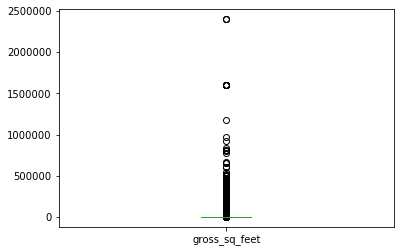

In [14]:
fig1 = property_df['gross_sq_feet'].plot.box()

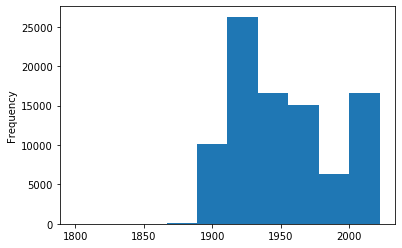

In [15]:
fig2 = property_df['year_built'].plot.hist()

In [16]:
# Dropping resi/comm_units
property_df = property_df.drop(columns = ['resi_units', 'comm_units'])

# Mean imputing year_built
year_mean = property_df['year_built'].mean()
property_df['year_built'] = property_df['year_built'].fillna(value = year_mean)

## 2. Typecasting
Making sure that all columns are appropriately typed

There are several columns that we need to adjust the type for. They'll be listed below with their justifications

### Yellow data -
- RatecodeIDs: int - Column is made only of integers
- Location IDs: int - See above

In [17]:
columns = ['ratecode_id', 'pulocation_id', 'dolocation_id']
for column in columns:
    yellow = yellow.withColumn(
        column,
        f.col(column).astype('INT')
    )

### Property data -
- year_built: int - See above

In [18]:
# Casting year_built column to int
property_df = property_df.astype({'year_built': int})

## Filtering

There are ___ attributes that change the data drastically depending on their value. They are:

- ratecode_id: Depending on the `ratecode_id`, the trip data refers to airport trips, group rides or negotiated fare. In an earlier assumption, I posited that shared rides wouldn't have an overt effect on fare / distance / tip, so left that in. However, airport trips and negotiated fares would. They also make up a tiny part of the overall dataset -
- payment_type: As this analysis is interested in tips, it has been provided in the data dictionary that tips are only recorded for payment_type = 1. That is, a credit card was used. Other values of payment_type have no tip recorded, and if put into a model, will introduce massive bias
- Manual inspection of the data also revealed that 

In [19]:
# Filtering relevant rows based on ratecode_id value and overwriting unfiltered yellow dataframe

df_1 = yellow.select('*').where(yellow['ratecode_id'] == 1)
df_2 = yellow.select('*').where(yellow['ratecode_id'] == 6)

original_yellow = yellow.count()

print(f'Full yellow dataset has {original_yellow} rows\n')
print(f'ratecode_id = 1 has {df_1.count()} rows')
print(f'ratecode_id = 2 has {df_2.count()} rows\n')

yellow = df_1.union(df_2)
print(f'Filtered yellow dataset has {yellow.count()} rows')
print(f'Should have {df_1.count() + df_2.count()} rows')

percentage = yellow.count() / original_yellow
print(f'{round(percentage * 100, 2)}% of rows retained')

Full yellow dataset has 12671164 rows

ratecode_id = 1 has 11705675 rows
ratecode_id = 2 has 109 rows

Filtered yellow dataset has 11705784 rows
Should have 11705784 rows
92.38% of rows retained


In [20]:
df_3 = yellow.select('*').where(yellow['payment_type'] == 1)

print(f'payment_type = 1 has {df_3.count()} rows')
print(f'Filtered yellow has {yellow.count()} rows')

print(f'{round(df_3.count() / yellow.count() * 100, 2)}% of rows retained')

yellow = yellow.select('*').where(yellow['payment_type'] == 1)

payment_type = 1 has 9244878 rows
Filtered yellow has 11705784 rows
78.98% of rows retained


In [21]:
# Negative amount values can be seen. Even for just these 10 rows displayed, if one were to make the argument that a - sign was
# input incorrectly, the tip_amount still far outweighs the total_amount in most cases. This is either money laundering or 
# errors

display(yellow.orderBy('total_amount').limit(10))

yellow = yellow.select('*').where(yellow['total_amount'] > 0)

# Follow similar (real-world) logic to filter out incorrect values for other attributes
yellow = yellow.select('*').where(yellow['trip_distance'] > 0)
yellow = yellow.select('*').where(yellow['fare_amount'] > 0)
yellow = yellow.select('*').where(yellow['tip_amount'] > 0)

percentage = round(yellow.count() / original_yellow * 100, 2)
print(f'After all that, yellow is left with {yellow.count()}: {percentage}% of original size')

tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,ratecode_id,pulocation_id,dolocation_id,payment_type,fare_amount,tip_amount,total_amount
2022-03-04 00:02:00,2022-03-04 00:25:34,8.06,1,138,152,1,-26.0,-75.26,-110.36
2022-01-20 17:16:29,2022-01-20 17:23:30,1.18,1,249,125,1,-6.5,-98.01,-108.81
2022-02-27 14:53:46,2022-02-27 15:17:28,2.23,1,113,230,1,-15.5,-76.1,-94.9
2022-03-23 09:43:57,2022-03-23 10:24:32,13.23,1,186,182,1,-42.0,-45.3,-90.6
2022-04-01 17:29:49,2022-04-01 18:13:57,10.53,1,132,171,1,-36.5,-45.0,-84.55
2022-02-06 14:06:22,2022-02-06 14:08:51,0.34,1,13,13,1,-3.5,-68.2,-75.0
2022-03-11 05:41:29,2022-03-11 06:03:29,9.28,1,132,98,1,-27.0,-35.0,-64.55
2022-02-20 06:03:40,2022-02-20 06:27:19,6.4,1,186,217,1,-23.0,-27.0,-53.8
2022-02-25 15:02:19,2022-02-25 15:24:45,6.38,1,100,231,1,-22.0,-5.06,-30.36
2022-04-14 21:01:18,2022-04-14 21:24:00,5.12,1,114,62,1,-19.5,-4.66,-27.96


After all that, yellow is left with 8933245: 70.5% of original size


## 4. Outlier Removal 
Outliers have to be dealt with appropriately, as they can skew data

### Yellow -

Since we're dealing with pricing & trip data for taxis, and that around 280,000 taxi rides happen each day, I'd say that 280,000 * 30 * 4 is a sufficiently large sample size for the Central Limit Theorem to apply. We're left with just under 9 million rows after filtering, assumption holds

Therefore outlier removal won't be overly complex - simply remove whats beyond the IQR for each feature

In [22]:
pd_numeric_yellow = yellow.select(f.col('total_amount'), f.col('fare_amount'), f.col('tip_amount'), f.col('trip_distance')).toPandas()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3453672400>,
      dtype=object)

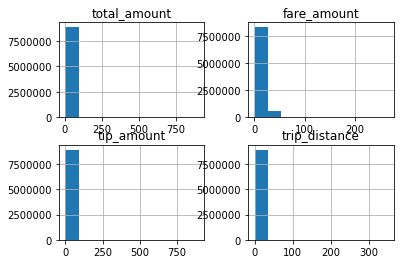

In [23]:
pd_numeric_yellow.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f339e571760>,
      dtype=object)

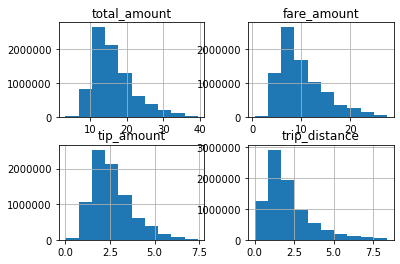

In [24]:
# Code taken from https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-a-pandas-dataframe
# Searched for 'remove outliers pd df'
# Code calculates the z-score for each value column-wise and filters out any values outside of 2 standard deviations

from scipy import stats
import numpy as np

pd_numeric_yellow = pd_numeric_yellow[(np.abs(stats.zscore(pd_numeric_yellow)) < 2).all(axis=1)]
pd_numeric_yellow.hist()

# Not sure why the axes are messed up, tried playing around with it but couldn't figure it out
# Not worth investing more time since I'm not going to use these visualisations in report, but I took the array of column 
# values and plotted them in R, got a similar shape, so it worked at least

# Additionally, the rows filtered out in this step still exist in the categorical_yellow df, and I can't figure out how to
# keep it consistent, so data will be split here into categorical and numerical. Would have had to split later on anyway

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f33a1aa54c0>,
      dtype=object)

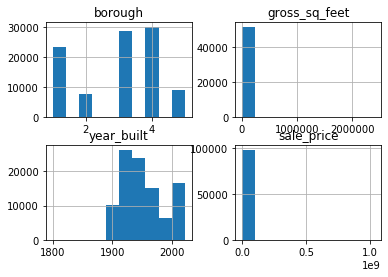

In [25]:
property_df.hist()

In [27]:
property_numerical = pd.DataFrame

In [30]:
property_numerical['gross_sq_feet'] = property_df.gross_sq_feet
#property_numerical['sale_price'] = property_df['sale_price']

TypeError: 'type' object does not support item assignment

In [ ]:
property_df['gross_sq_feet'] = property_df['gross_sq_feet'][(np.abs(stats.zscore(property_df['gross_sq_feet'])) < 2).all(axis=1)]

property_df['sale_price'] = property_df['sale_price'][(np.abs(stats.zscore(property_df['sale_price'])) < 2).all(axis=1)]

property_df.hist()

## 5. Unit Conversion

- `[pu/do]location_id`: Geometry conversion as covered in Tutorial 2
- `trip_distance`: Units are American - convert to metric units
- all `fare` quantities are in USD

### Converting PU/DOLocation to Geometry 
Code attributed to tute2

In [ ]:
sf = gpd.read_file("../raw_data/taxi_zones.shp")
zones = pd.read_csv("../raw_data/taxi+_zone_lookup.csv")

In [ ]:
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

## Trip Distance

Mile -> Km conversion is 1.6 * miles = km

In [ ]:
pd_numeric_yellow['trip_distance'] = pd_numeric_yellow['trip_distance'] * 1.6

## Fare
USD -> AUD for interpretability
Using current FX rates at time of writing this. Will be slightly different, but an incorrect / outdated conversion rate wouldn't affect results of study

Current conversion rate: 1 USD = 1.44 AUD

In [ ]:
pd_numeric_yellow['total_amount'] = pd_numeric_yellow['total_amount'] * 1.44
pd_numeric_yellow['fare_amount'] = pd_numeric_yellow['fare_amount'] * 1.44
pd_numeric_yellow['tip_amount'] = pd_numeric_yellow['tip_amount'] * 1.44

In [ ]:
yellow_numerical = spark.createDataFrame(pd_numeric_yellow)
yellow_categorical = yellow.select(f.col('tpep_pickup_datetime'), f.col('tpep_dropoff_datetime'), \
                                   f.col('ratecode_id'), f.col('pulocation_id'), f.col('dolocation_id'), \
                                   f.col('payment_type'))

In [ ]:
import os

In [ ]:
output_relative_dir = '../raw_data/'
target_dir = 'clean_data/'
if not os.path.exists(output_relative_dir + target_dir):
    os.makedirs(output_relative_dir + target_dir)

In [ ]:
yellow_numerical.write.parquet('../clean_data/yellow_numerical')
yellow_categorical.write.parquet('../clean_data/yellow_categorical')

In [ ]:
t2 = datetime.now()

time_taken = t2 - t1
print(f'This notebook took {time_taken} to run.')
minutes_taken = round(time_taken.total_seconds() / 60, 2)
print(f'This notebook took {minutes_taken} minutes to run.')